In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


def data_generator():
    # input image dimensions
    img_rows, img_cols = 28, 28
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, img_rows * img_cols, 1)
    x_test = x_test.reshape(-1, img_rows * img_cols, 1)

    num_classes = 10
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    y_train = np.expand_dims(y_train, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    return (x_train, y_train), (x_test, y_test)

In [2]:
import inspect
from typing import List

from tensorflow.keras import backend as K, Model, Input, optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization


def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.layers_outputs = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                self._build_layer(Activation(self.activation))
                self._build_layer(SpatialDropout1D(rate=self.dropout_rate))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape
                    self.shape_match_conv = Conv1D(filters=self.nb_filters,
                                                   kernel_size=1,
                                                   padding='same',
                                                   name=name,
                                                   kernel_initializer=self.kernel_initializer)
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation))
            self.final_activation = Activation(self.activation)
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        x = inputs
        self.layers_outputs = [x]
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x = layer(x, training=training) if training_flag else layer(x)
            self.layers_outputs.append(x)
        x2 = self.shape_match_conv(inputs)
        self.layers_outputs.append(x2)
        res_x = layers.add([x2, x])
        self.layers_outputs.append(res_x)

        res_act_x = self.final_activation(res_x)
        self.layers_outputs.append(res_act_x)
        return [res_act_x, x]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]


class TCN(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=3,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        return 1 + 2 * (self.kernel_size - 1) * self.nb_stacks * sum(self.dilations)

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :])

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None):
        x = inputs
        self.layers_outputs = [x]
        self.skip_connections = []
        for layer in self.residual_blocks:
            try:
                x, skip_out = layer(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = layer(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            x = layers.add(self.skip_connections)
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        return config


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 output_len=1,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=False,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 kernel_initializer='he_normal',  # type: str,
                 activation='relu',  # type:str,
                 opt='adam',
                 lr=0.002,
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False):
    # type: (...) -> Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.
    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        activation: The activation used in the residual blocks o = Activation(x + F(x)).
        name: Name of the model. Useful when having multiple TCN.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        opt: Optimizer name.
        lr: Learning rate.
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
        use_layer_norm: Whether to use layer normalization in the residual layers or not.
        use_weight_norm: Whether to use weight normalization in the residual layers or not.
    Returns:
        A compiled keras TCN.
    """

    dilations = adjust_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences,
            activation, kernel_initializer, use_batch_norm, use_layer_norm,
            use_weight_norm, name=name)(input_layer)

    print('x.shape=', x.shape)

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=[accuracy])
    else:
        # regression
        x = Dense(output_len)(x)
        x = Activation('linear')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error')
    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))
    return model


def tcn_full_summary(model: Model, expand_residual_blocks=True):
    layers = model._layers.copy()  # store existing layers
    model._layers.clear()  # clear layers

    for i in range(len(layers)):
        if isinstance(layers[i], TCN):
            for layer in layers[i]._layers:
                if not isinstance(layer, ResidualBlock):
                    if not hasattr(layer, '__iter__'):
                        model._layers.append(layer)
                else:
                    if expand_residual_blocks:
                        for lyr in layer._layers:
                            if not hasattr(lyr, '__iter__'):
                                model._layers.append(lyr)
                    else:
                        model._layers.append(layer)
        else:
            model._layers.append(layers[i])

    model.summary()  # print summary

    # restore original layers
    model._layers.clear()
    [model._layers.append(lyr) for lyr in layers]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

         Date     Open     High      Low    Close  Volume
0  29-Mar-2019  3300.0  3348.00  3265.00  3326.00   33841
1  28-Mar-2019  3251.0  3321.00  3230.00  3290.25   22424
2  27-Mar-2019  3220.6  3287.95  3191.05  3267.10   26351
3  26-Mar-2019  3165.0  3287.95  3144.00  3230.00   31056
4  25-Mar-2019  3166.0  3200.05  3135.00  3180.65   15472

****
             Date     Open   High     Low   Close  Volume
2717  07-Apr-2008  672.35  694.5  662.15  685.90    5877
2718  04-Apr-2008  673.00  684.5  669.00  672.35   14869
2719  03-Apr-2008  675.00  691.8  669.10  684.05   11378
2720  02-Apr-2008  695.10  720.0  691.00  700.35   16497
2721  01-Apr-2008  700.00  700.0  675.00  694.70   14215
_________________________________________________________

OPEN 
	Average :  1502.7655951506233 
	Maximum :  3735.0 
	Minimum :  450.0 
	Standard Deviation :  646.3160392814301


HIGH 
	Average :  1524.758082292438 
	Maximum :  3847.7 
	Minimum :  454.1 
	Standard Deviation :  655.7471248643697


LOW 


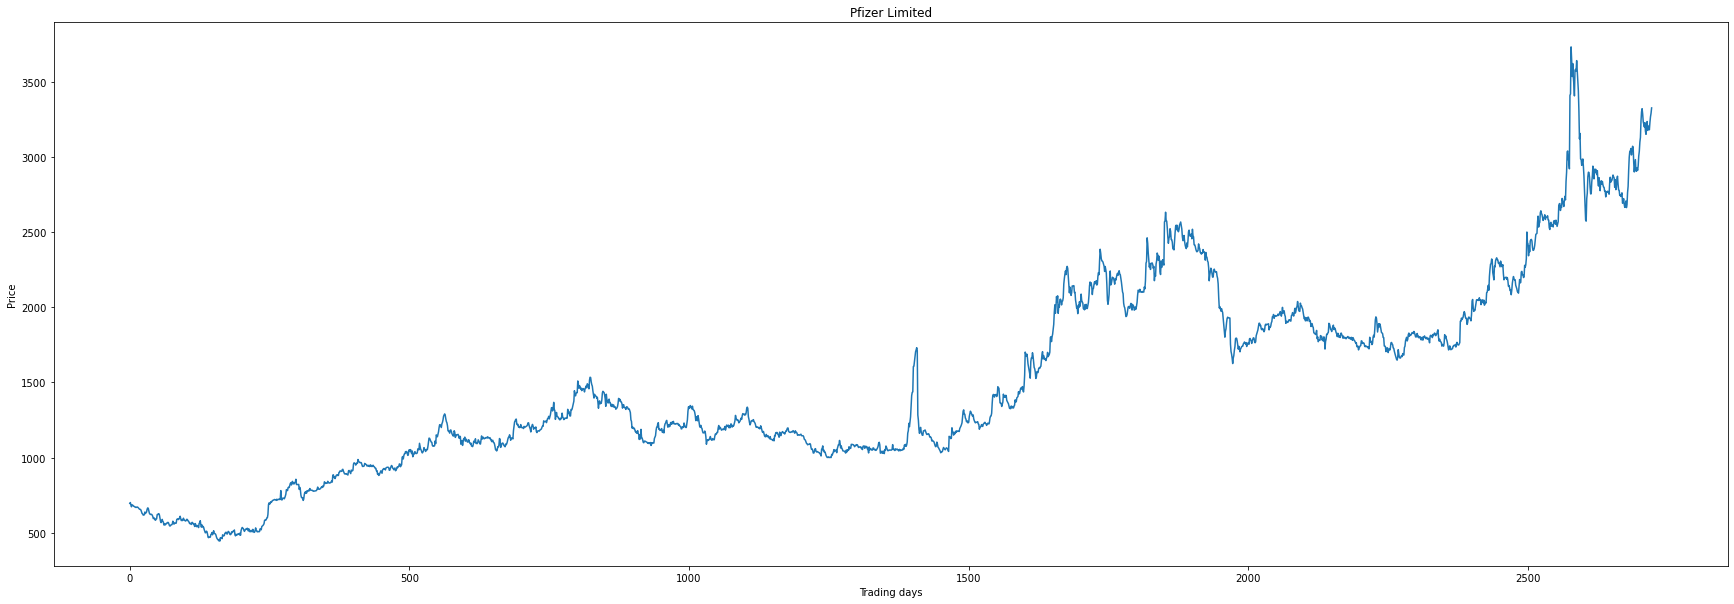

In [4]:
import numpy as np
import pandas as pd

df = pd.read_excel("/home/shravan/Desktop/Datasets/pharma/pfizer/pfizer.xlsx")

print(df.head())
print("\n****\n",df.tail())

print("_________________________________________________________\n\nOPEN \n\tAverage : ",np.mean(df.loc[:]['Open']),"\n\tMaximum : ", np.max(df['Open']),"\n\tMinimum : ", np.min(df['Open']),"\n\tStandard Deviation : ", np.std(df['Open']))
print("\n\nHIGH \n\tAverage : ",np.mean(df.loc[:]['High']),"\n\tMaximum : ", np.max(df['High']),"\n\tMinimum : ", np.min(df['High']),"\n\tStandard Deviation : ", np.std(df['High']))
print("\n\nLOW \n\tAverage : ",np.mean(df.loc[:]['Low']),"\n\tMaximum : ", np.max(df['Low']),"\n\tMinimum : ", np.min(df['Low']),"\n\tStandard Deviation : ", np.std(df['Low']))
print("\n\nCLOSE \n\tAverage : ",np.mean(df.loc[:]['Close']),"\n\tMaximum : ", np.max(df['Close']),"\n\tMinimum : ", np.min(df['Close']),"\n\tStandard Deviation : ", np.std(df['Close']))
print("\n\nVOLUME \n\tAverage : ",np.mean(df.loc[:]['Volume']),"\n\tMaximum : ", np.max(df['Volume']),"\n\tMinimum : ", np.min(df['Volume']),"\n\tStandard Deviation : ", np.std(df['Volume']))

def reverse_data(df):
    date = []
    day = []
    open = []
    high = []
    low = []
    close = []
    volume = []
    for i in range(len(df)-1, -1, -1):
        day.append((len(df)-1)-i)
        date.append(df.loc[i]['Date '])
        open.append(df.loc[i]['Open'])
        high.append(df.loc[i]['High'])
        low.append(df.loc[i]['Low'])
        close.append(df.loc[i]['Close'])
        volume.append(df.loc[i]['Volume'])
    stocks = pd.DataFrame()
    stocks['Day'] = day
    stocks['Date'] = date
    stocks['Open'] = open
    stocks['High'] = high
    stocks['Low'] = low
    stocks['Close'] = close
    stocks['Volume'] = volume
    return stocks

stocks = reverse_data(df)

print(stocks.head())
print("\n****\n",stocks.tail())

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,10)
fig,ax = plt.subplots()

ax.plot(stocks['Day'],stocks['Close'])
plt.xlabel("Trading days")
plt.ylabel("Price")
plt.title("Pfizer Limited")
plt.show()

   Day         Date      Open      High       Low     Close    Volume
0    0  01-Apr-2008  0.076104  0.072460  0.075888  0.076263  0.021924
1    1  02-Apr-2008  0.074612  0.078353  0.080947  0.077982  0.025462
2    2  03-Apr-2008  0.068493  0.070044  0.074023  0.073024  0.017525
3    3  04-Apr-2008  0.067884  0.067893  0.073991  0.069466  0.022938
4    4  07-Apr-2008  0.067686  0.070839  0.071825  0.073587  0.008996

****
        Day         Date      Open      High       Low     Close    Volume
2717  2717  25-Mar-2019  0.826788  0.809155  0.853741  0.832342  0.023873
2718  2718  26-Mar-2019  0.826484  0.835057  0.856587  0.847352  0.048035
2719  2719  27-Mar-2019  0.843409  0.835057  0.871464  0.858635  0.040740
2720  2720  28-Mar-2019  0.852664  0.844796  0.883780  0.865676  0.034651
2721  2721  29-Mar-2019  0.867580  0.852752  0.894848  0.876549  0.052353


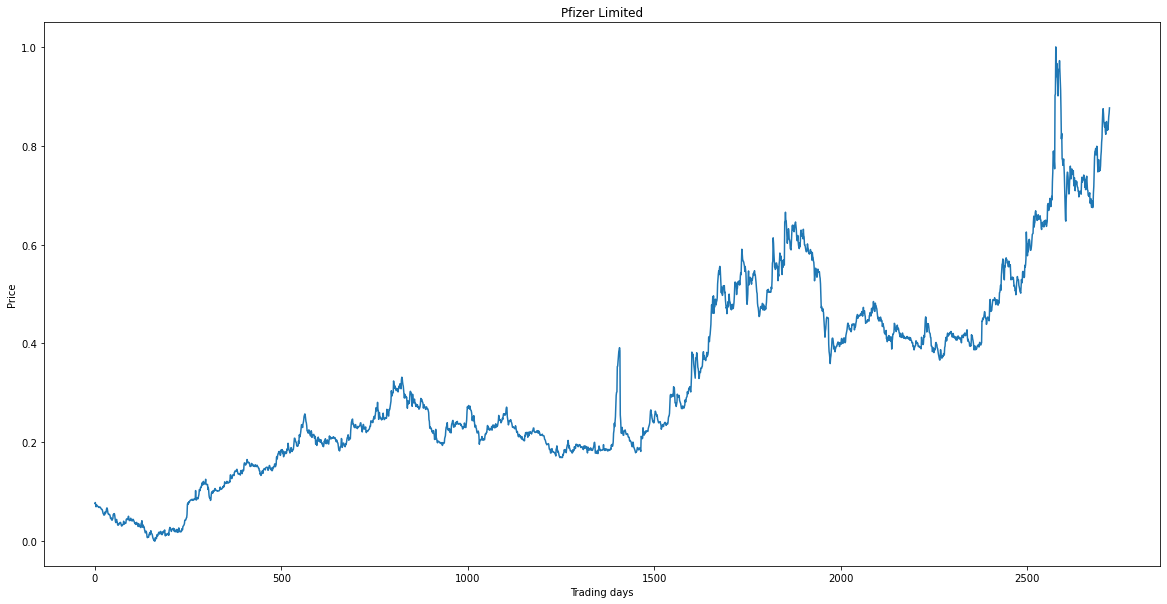

In [5]:
from sklearn.preprocessing import MinMaxScaler

def get_normalised_data(data):
    scaler = MinMaxScaler()
    numerical = ['Open','High','Low','Close','Volume']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

stocks = get_normalised_data(stocks)

print(stocks.head())
print("\n****\n",stocks.tail())

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)
fig,ax = plt.subplots()

ax.plot(stocks['Day'],stocks['Close'])
plt.xlabel("Trading days")
plt.ylabel("Price")
plt.title("Pfizer Limited")
plt.show()

In [6]:
import math
from IPython.display import display
import time
from keras.layers.core import Dense,Dropout,Activation
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers.recurrent import SimpleRNN

#UNROLL_FUNCTION
def unroll(stocks,unroll_length):
    result = []
    for i in range(len(stocks)-unroll_length+1):
        result.append(stocks[i : (i+unroll_length)])
    return np.asarray(result)

In [7]:
stocks = stocks.drop(['Date','Day'], axis =1)
stocks.head()

def train_test_split(stocks,unroll_length,prediction_size,prediction_time):
    x_test_start = prediction_size + prediction_time + unroll_length - 1
    
    #train data
    x_train = stocks[0 : (-x_test_start - prediction_time)].to_numpy()
    y_train = stocks[ (unroll_length - 1 + prediction_time) : -x_test_start]['Close'].to_numpy()
    
    #test_data
    x_test = stocks[-x_test_start : -prediction_time].to_numpy()
    y_test = stocks[-prediction_size:]['Close'].to_numpy()

    
    return x_train,x_test,y_train,y_test

prediction_size = 494
prediction_time = 5
unroll_length = 50

x_train,x_test,y_train,y_test = train_test_split(stocks,unroll_length,prediction_size,prediction_time)

x_train = unroll(x_train,unroll_length)
x_test = unroll(x_test,unroll_length)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2120, 50, 5)
y_train (2120,)
x_test (494, 50, 5)
y_test (494,)


In [8]:
model = Sequential([
    TCN(input_shape=(50, 5),
        kernel_size=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear')
])

model.summary()
model.compile('adam', 'mse')

print('Train...')
model.fit(x_train, y_train, epochs=100, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                91904     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 91,969
Trainable params: 91,969
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/100
67/67 - 13s - loss: 0.4696
Epoch 2/100
67/67 - 6s - loss: 0.0042
Epoch 3/100
67/67 - 6s - loss: 0.0038
Epoch 4/100
67/67 - 6s - loss: 0.0023
Epoch 5/100
67/67 - 7s - loss: 0.0018
Epoch 6/100
67/67 - 7s - loss: 0.0014
Epoch 7/100
67/67 - 7s - loss: 0.0013
Epoch 8/100
67/67 - 7s - loss: 0.0023
Epoch 9/100
67/67 - 7s - loss: 0.0012
Epoch 10/100
67/67 - 6s - loss: 0.0011
Epoch 11/100
67/67 - 7s - loss: 8.1859e-04
Epoch 12/100
67/67 - 7s - loss: 8.9279e-04
Epoch 13/100
67/67 - 6s - loss: 8.845

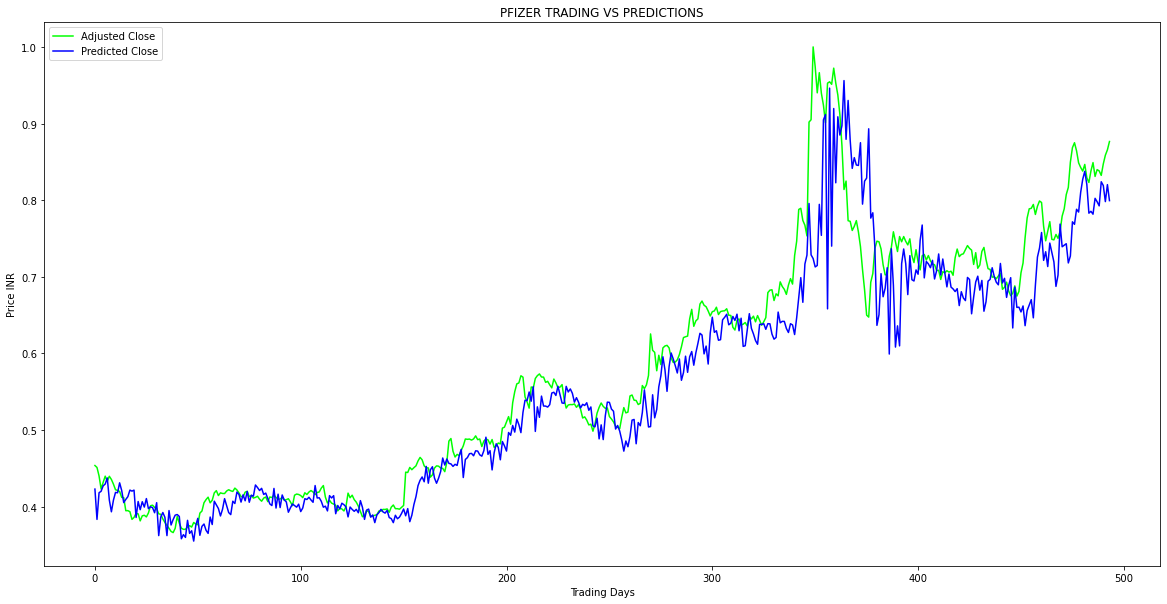

Standard Deviation of Error :  0.21564801836124856
Denormalised Standard Deviation :  709.0399019708673
Ratio of Standard Deviation of Error to Standard Deviation of Stock Price :  1.0983082820245178
Train Score: 0.00034308 MSE (0.01852242 RMSE)
Test Score: 0.00277450 MSE (0.05267351 RMSE)


In [9]:
def plot_prediction(actual, prediction, title='PFIZER TRADING VS PREDICTIONS', y_label='Price INR', x_label='Trading Days'):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values
    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()
    return fig




def err_stat(y_test,preds):
    Error = preds - y_test
    print("Standard Deviation of Error : ", np.std(Error))
    stdErr = np.std(Error)
    DstdErr = stdErr * (np.max(df['Close']) - np.min(df['Close']))
    print("Denormalised Standard Deviation : ", DstdErr)
    print("Ratio of Standard Deviation of Error to Standard Deviation of Stock Price : ", DstdErr/np.std(df['Close']))



preds = model.predict(x_test)
plot_prediction(y_test, preds)
err_stat(y_test,preds)

trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))